In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql.types import *
import seaborn as sns
import pyspark.sql.functions as func
import matplotlib.pyplot as plt
import numpy as np


In [2]:
sc = SparkContext()

In [3]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [4]:
youtube_data = sqlContext.read.format('csv').option("header", "true").option("inferSchema", "true").load('USvideos.csv')


In [5]:
youtube_category = sqlContext.read.format('json').options(multiline = 'true', inferschema = 'true').load("US_category_id.json")
cat = youtube_category.select('items.id', 'items.snippet.title').collect()
cat

[Row(id=['1', '2', '10', '15', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44'], title=['Film & Animation', 'Autos & Vehicles', 'Music', 'Pets & Animals', 'Sports', 'Short Movies', 'Travel & Events', 'Gaming', 'Videoblogging', 'People & Blogs', 'Comedy', 'Entertainment', 'News & Politics', 'Howto & Style', 'Education', 'Science & Technology', 'Nonprofits & Activism', 'Movies', 'Anime/Animation', 'Action/Adventure', 'Classics', 'Comedy', 'Documentary', 'Drama', 'Family', 'Foreign', 'Horror', 'Sci-Fi/Fantasy', 'Thriller', 'Shorts', 'Shows', 'Trailers'])]

In [6]:
# youtube_data.join(cat, youtube_data.category_id == cat.id).collect()
cat_title = []
for i in range(len(cat[0][0])):
    cat_title.append((cat[0][0][i],cat[0][1][i]))

schemaString = "category_id video_title"

fields = [StructField(field_name, StringType(), True) for field_name in schemaString.split()]
schema = StructType(fields)

spark_cat = sqlContext.createDataFrame(cat_title, schema)


In [7]:
youtube_data_set =youtube_data.join(spark_cat, youtube_data.category_id == spark_cat.category_id).drop(spark_cat.category_id).select('*')

# youtube_data.select('category_id').show()

In [8]:
# youtube_data_set.describe(['category_id']).show()
youtube_likes_dislikes = youtube_data_set.groupBy('video_title').agg(func.sum('likes').alias('like_count'), 
                                                                     func.sum('dislikes').alias('dislike_count'), 
                                                                     func.sum('comment_count').alias('comment_count'))
youtube_likes_dislikes = youtube_likes_dislikes.withColumn('total', sum([youtube_likes_dislikes[col] for col in ['like_count','dislike_count','comment_count']]))


In [9]:
# Storing the dataframe in csv
youtube_likes_dislikes.coalesce(1).write.format('csv').option("header", "true") .csv('csv_youtube_likes_dislikes')
youtube_likes_dislikes.show()

+--------------------+-------------+-------------+-------------+-------------+
|         video_title|   like_count|dislike_count|comment_count|        total|
+--------------------+-------------+-------------+-------------+-------------+
|               Shows|    1082639.0|      24508.0|      95117.0|    1202264.0|
|           Education|  4.9257772E7|    1351972.0|    5442242.0|  5.6051986E7|
|              Gaming|  6.9038284E7|    9184466.0|  1.4740713E7|  9.2963463E7|
|       Entertainment| 5.30516491E8|  4.2987663E7|  7.3566498E7| 6.47070652E8|
|     Travel & Events|    4836246.0|     340427.0|     911511.0|    6088184.0|
|Science & Technology|  8.2532638E7|    4548402.0|  1.1989926E7|  9.9070966E7|
|              Sports|  9.8621211E7|    5133551.0|  1.1192155E7| 1.14946917E8|
|       Howto & Style| 1.62880075E8|    5473899.0|   2.314955E7| 1.91503524E8|
|Nonprofits & Acti...|  1.4815646E7|    3310381.0|    4808797.0|  2.2934824E7|
|    Film & Animation| 1.65997476E8|    6075148.0|  

In [10]:
# youtube_data_set.filter(youtube_data_set.comments_disabled == True).select('comments_disabled','comment_count').show()

# for row in youtube_likes_dislikes.collect():
#     percent_like = row.like_count/row.total
#     percent_dislike = row.dislike_count/row.total
#     percent_comment = row.comment_count/row.total
#     size_of_groups = [percent_like, percent_dislike, percent_comment]
#     plt.pie(size_of_groups)
#     my_circle=plt.Circle( (0,0), 0.7, color='white')
#     p=plt.gcf()
#     p.gca().add_artist(my_circle)

#     plt.show()


list_likes = [i.like_count for i in youtube_likes_dislikes.select(youtube_likes_dislikes.like_count.cast('int ')).collect()]
list_dislikes =[i.dislike_count for i in youtube_likes_dislikes.select(youtube_likes_dislikes.dislike_count.cast('int')).collect()]
list_comments = [i.comment_count for i in youtube_likes_dislikes.select(youtube_likes_dislikes.comment_count.cast('int')).collect()]
list_titles = [i.video_title for i in youtube_likes_dislikes.select('video_title').collect()]



In [11]:
def plot_likes_dislikes_comments(list_likes, list_dislikes, list_comments, list_titles):
    fig, ax = plt.subplots(figsize=(40, 10))
    bar_width = .2
    index = 2*np.arange(len(list_titles))
    print(index)
    opacity = 0.4

    rects1 = ax.bar(index, tuple(list_likes), bar_width,
                    alpha=opacity, color='b',
                    label='Likes')

    rects2 = ax.bar(index + bar_width, tuple(list_dislikes), bar_width,
                    alpha=opacity, color='r',
                    label='Dislikes')
    rects3 = ax.bar(index + bar_width + bar_width, tuple(list_comments), bar_width,
                    alpha=opacity, color='g',
                    label='Comments')

    plt.xlabel('Categories')
    plt.ylabel('Count')
    plt.title('Likes-Dislikes-Comments per trending category')
    plt.xticks(index+bar_width, tuple(list_titles))
    plt.legend()
    plt.setp(ax.get_xticklabels(), rotation = 30, horizontalalignment = 'right')

    plt.tight_layout()
    plt.show()

[ 0  2  4  6  8 10 12 14 16 18 20 22 24 26 28 30]


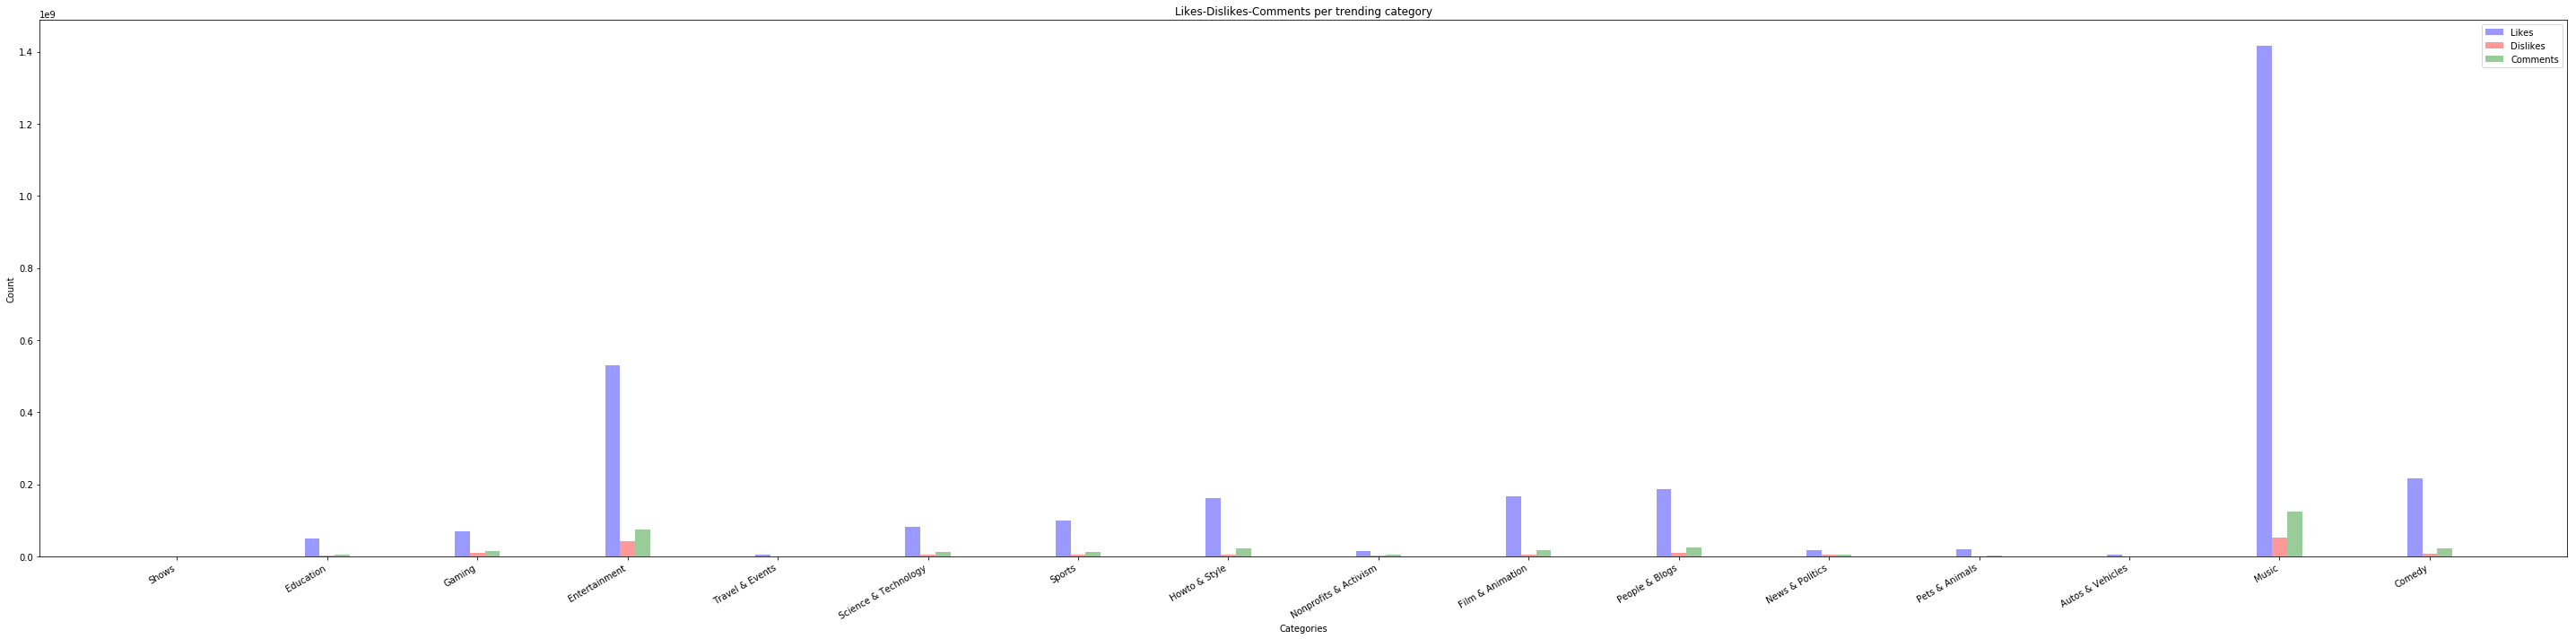

In [12]:
plot_likes_dislikes_comments(list_likes, list_dislikes, list_comments, list_titles)

In [13]:
youtube_likes_dislikes.select('*').groupBy().agg(func.mean('dislike_count'), func.mean('like_count'), func.mean('comment_count')).show()

+------------------+---------------+------------------+
|avg(dislike_count)|avg(like_count)|avg(comment_count)|
+------------------+---------------+------------------+
|      9498634.6875|1.90071699875E8|     2.161801025E7|
+------------------+---------------+------------------+

